# Sparkify Project Workspace

In [1]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, CountVectorizer,IDF, StringIndexer, Normalizer
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import when, col
import re
from pyspark.sql.functions import count
from pyspark.sql import Window
from pyspark.sql.functions import desc
from pyspark.sql.functions import collect_list
from pyspark.sql.functions import lag, row_number

import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import numpy as np
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier

In [2]:
import os
os.environ['JAVA_HOME'] = '/workspace/jdk'
os.environ['PATH'] = f"{os.environ['JAVA_HOME']}/bin:{os.environ['PATH']}"

In [3]:
# create a Spark session

spark = SparkSession.builder \
    .master("local") \
    .appName("Capstone") \
    .getOrCreate()

/opt/venv/lib/python3.10/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/09 17:50:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Clean Dataset

In [4]:
# variable of the mini-dataset file

sparkify_data = 'mini_sparkify_event_data.json'

In [5]:
# load in the dataset

df = spark.read.json(sparkify_data)

# Exploratory Data Analysis

In [6]:
# look at the first row of the dataset

df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [7]:
# how many rows are in the dataset

df.count()

286500

In [8]:
# how many users are a part of this dataset

no_unique_users = df.select('userId').dropDuplicates().count()
no_unique_users

226

### Define Churn

In [9]:
# how many of the users have 'churned'

df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

In [10]:
# defining the churn column using a lamda function and assigning as an integer.

churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [11]:
# applying this to the dataset, using the page column.

df = df.withColumn("Churn", churn("page"))

In [12]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0)

In [13]:
# creating a list of all the users who have churned.

have_churned_df = df.where(df.Churn == 1)
churned_users = have_churned_df.select('userId').rdd.flatMap(lambda x: x).collect()

In [14]:
# creating two separate datasets for users who have and haven't churned.

non_churned_df = df.where(~col('userId').isin(churned_users))
churned_df = df.where(col('userId').isin(churned_users))

In [15]:
non_churned_df_users = non_churned_df.dropDuplicates(['userId'])
churned_df_users = churned_df.dropDuplicates(['userId'])

### Explore Data

## By level analysis

**As the dataset is now seperated into two, we can look if there's any noticable difference in behaviour between the two groups. Firstly, we'll look into if users who are using the 'free' level are more likely to churn than those who's using the 'paid' level.**

In [16]:
# Starting with the churned dataset, we'll count how many of them are in each level.

churned_df_users.groupby(churned_df_users.level).agg(count('*').alias('no_level_customers')).collect()

[Row(level='free', no_level_customers=44),
 Row(level='paid', no_level_customers=8)]

In [17]:
# Do the same with the non-churned dataset.

non_churned_df_users.groupby(non_churned_df_users.level).agg(count('*').alias('no_level_customers')).collect()

[Row(level='free', no_level_customers=134),
 Row(level='paid', no_level_customers=40)]

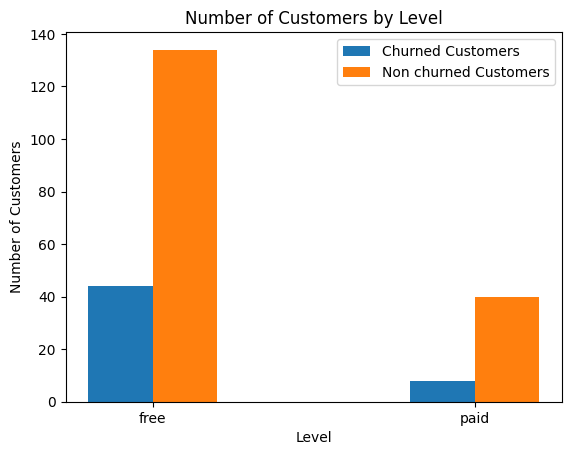

In [18]:
# Now we have all the data, this can be plotted in a bar plot to see the comparison between the two customers.

level = ['free', 'paid']
no_customers_churned = [44, 8]
no_customers_non_churned = [134, 40]
width = 0.2
r1 = np.arange(len(level))
r2 = [x + width for x in r1]

plt.bar(r1, no_customers_churned, width = width, label = 'Churned Customers')
plt.bar(r2,  no_customers_non_churned,width = width , label = 'Non churned Customers')
plt.xlabel('Level')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Level')
plt.xticks([r + width/2 for r in range(len(level))], level)

plt.legend()
plt.show()

In [19]:
free_level_churn_rate = 44/(44+134)
free_level_churn_rate

0.24719101123595505

In [20]:
paid_level_churn_rate = 8/(8+40)
paid_level_churn_rate

0.16666666666666666

**We can see that the churn rate is significantly higher for those using the 'free' level.** 

## By gender analysis

**We can do the same analysis however this type see if gender has an effect.**

In [21]:
#  Starting with the churned dataset, we'll see what the gender divide is.

churned_df_users.groupby(churned_df_users.gender).agg(count('*').alias('gender_count')).collect()

[Row(gender='F', gender_count=20), Row(gender='M', gender_count=32)]

In [22]:
# Do the same to the non-churned dataset.

non_churned_df_users.groupby(non_churned_df_users.gender).agg(count('*').alias('gender_count')).collect()

[Row(gender='F', gender_count=84),
 Row(gender=None, gender_count=1),
 Row(gender='M', gender_count=89)]

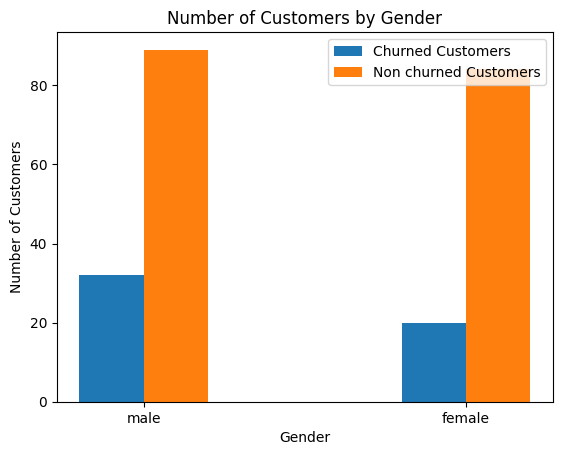

In [23]:
# Plot this data in the same method as above.

gender = ['male', 'female']
no_customers_churned = [32, 20]
no_customers_non_churned = [89, 84]
width = 0.2
r1 = np.arange(len(gender))
r2 = [x + width for x in r1]

plt.bar(r1, no_customers_churned, width = width, label = 'Churned Customers')
plt.bar(r2,  no_customers_non_churned,width = width , label = 'Non churned Customers')
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Gender')
plt.xticks([r + width/2 for r in range(len(gender))], gender)

plt.legend()
plt.show()

In [24]:
male_churn_rate = 32/(32+89)
male_churn_rate

0.2644628099173554

In [25]:
female_churn_rate = 20/(20+84)
female_churn_rate

0.19230769230769232

**We can see that males are more likely to churn.**

## Songs Listened

In [26]:
# What is the average number of songs listened to.

avg_song_churned = (churned_df.select('song').count())/(churned_df_users.count())
avg_song_churned

862.7692307692307

In [27]:
avg_song_non_churned = (non_churned_df.select('song').count())/(non_churned_df_users.count())
avg_song_non_churned

1388.712643678161

**We can see that users who do not churn listen on average to a higher amount of songs.**

# Location

**Does location have an impact on churning?**

In [28]:
# Grouping the data by location and counting the occurances, then ranking by the most popular gives 
# us an idea of where most of the churned users are based. We can then compare the most popular locations 
# with the non-churned users.

churned_location = churned_df.select("location", "userId", "churn").groupby("location").count()
churned_location.sort('count', ascending=False).show(10)

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Los Angeles-Long ...| 5677|
|         Jackson, MS| 3839|
|Spokane-Spokane V...| 3526|
|New York-Newark-J...| 2899|
|Lexington-Fayette...| 2464|
|Colorado Springs, CO| 2168|
|Denver-Aurora-Lak...| 2149|
|           Selma, AL| 2027|
|New Philadelphia-...| 1781|
|Philadelphia-Camd...| 1580|
+--------------------+-----+
only showing top 10 rows



In [29]:
non_churned_location = non_churned_df.select("location", "userId", "churn").groupby("location").count()
non_churned_location.sort('count', ascending=False).show(10)

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Los Angeles-Long ...|24454|
|New York-Newark-J...|20785|
|Boston-Cambridge-...|13873|
|Houston-The Woodl...| 8535|
|                NULL| 8346|
|Charlotte-Concord...| 7780|
|Dallas-Fort Worth...| 7286|
|Louisville/Jeffer...| 6880|
|Vineland-Bridgeto...| 4825|
|          Wilson, NC| 4659|
+--------------------+-----+
only showing top 10 rows



**We can see that the top 10 locations are different between the two datasets.**

# Length 

In [30]:
non_churned_df.agg(F.mean('length')).collect()[0][0]

249.20913538881427

In [31]:
churned_df.agg(F.mean('length')).collect()[0][0]

248.63279564406366

**We can see that the length feature doesn't vary between the two datasets.**

# Feature Engineering

In [32]:
# Create numeric variables for features we want to use.

df = spark.read.json(sparkify_data)
df = df.withColumn('numeric_gender', when(df.gender == 'f', 1).otherwise(0)) 
df = df.withColumn('numeric_level', when(df.level == 'paid', 1).otherwise(0)) 
df = df.withColumn('label', F.when(df['userId'].isin(churned_users), 1).otherwise(0))
df = df.withColumn('churn', when(df.page == "Cancellation Confirmation", 1).otherwise(0))

In [33]:
# We have identified the song feature as one which is significant therefore we want to ensure all the rows are in the 
# correct format.

df = df.withColumn("song", df["song"].cast('string'))

In [34]:
# Do the same to the location feature.

df = df.withColumn("location", df["location"].cast('string'))

In [35]:
# Drop any null values for these two features.

df = df.dropna(how = 'any', subset = ["song", "location"])

In [36]:
# split the location text into separate words

regexTokenizer = RegexTokenizer(inputCol="location", outputCol='location_words', pattern="\\W")
df = regexTokenizer.transform(df)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', numeric_gender=0, numeric_level=1, label=0, churn=0, location_words=['bakersfield', 'ca'])

In [37]:
# find the term frequencies of the location feature

cv = CountVectorizer(inputCol="location_words", outputCol="TF_location", vocabSize=1000)
cvmodel = cv.fit(df)
df = cvmodel.transform(df)

In [38]:
# Inter-document frequency.

idf = IDF(inputCol="TF_location", outputCol="TFIDF_location")
idfModel = idf.fit(df)
df = idfModel.transform(df)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', numeric_gender=0, numeric_level=1, label=0, churn=0, location_words=['bakersfield', 'ca'], TF_location=SparseVector(273, {0: 1.0, 155: 1.0}), TFIDF_location=SparseVector(273, {0: 1.7851, 155: 5.0806}))

In [39]:
# split the song text into separate words

regexTokenizer2 = RegexTokenizer(inputCol="song", outputCol='song_words', pattern="\\W")
df = regexTokenizer2.transform(df)
df.head()

24/12/09 17:51:17 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', numeric_gender=0, numeric_level=1, label=0, churn=0, location_words=['bakersfield', 'ca'], TF_location=SparseVector(273, {0: 1.0, 155: 1.0}), TFIDF_location=SparseVector(273, {0: 1.7851, 155: 5.0806}), song_words=['rockpools'])

In [40]:
# find the term frequencies of the song feature

cv2 = CountVectorizer(inputCol="song_words", outputCol="TF_song", vocabSize=1000)
cvmodel2 = cv2.fit(df)
df = cvmodel2.transform(df)

In [41]:
# Inter-document frequency.

idf2 = IDF(inputCol="TF_song", outputCol="TFIDF_song")
idfModel2 = idf2.fit(df)
df = idfModel2.transform(df)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', numeric_gender=0, numeric_level=1, label=0, churn=0, location_words=['bakersfield', 'ca'], TF_location=SparseVector(273, {0: 1.0, 155: 1.0}), TFIDF_location=SparseVector(273, {0: 1.7851, 155: 5.0806}), song_words=['rockpools'], TF_song=SparseVector(1000, {}), TFIDF_song=SparseVector(1000, {}))

In [42]:
# Combine all the numerical features into a vector.

assembler = VectorAssembler(inputCols=['TFIDF_location', "TFIDF_song", 'numeric_gender', 'numeric_level','sessionId', 'itemInSession'], outputCol='NumFeatures')
df = assembler.transform(df)

In [43]:
# Normalize the vector.

scaler = Normalizer(inputCol="NumFeatures", outputCol="ScaledNumFeatures")
df = scaler.transform(df)

In [44]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', numeric_gender=0, numeric_level=1, label=0, churn=0, location_words=['bakersfield', 'ca'], TF_location=SparseVector(273, {0: 1.0, 155: 1.0}), TFIDF_location=SparseVector(273, {0: 1.7851, 155: 5.0806}), song_words=['rockpools'], TF_song=SparseVector(1000, {}), TFIDF_song=SparseVector(1000, {}), NumFeatures=SparseVector(1277, {0: 1.7851, 155: 5.0806, 1274: 1.0, 1275: 29.0, 1276: 50.0}), ScaledNumFeatures=SparseVector(1277, {0: 0.0307, 155: 0.0875, 1274: 0.0172, 1275: 0.4995, 1276: 0.8612}))

In [45]:
# Checking we still have the correct amount of users.

check_no_unique_users = df.select('userId').dropDuplicates().count()
check_no_unique_users

225

# Modeling

In [46]:
# Split the dataset

train_data, test_data, validation_data = df.randomSplit([0.7, 0.2, 0.1], seed=42)

In [47]:
train_data.head()

Row(artist='!!!', auth='Logged In', firstName='Brayden', gender='M', itemInSession=279, lastName='Thomas', length=356.10077, level='paid', location='Los Angeles-Long Beach-Anaheim, CA', method='PUT', page='NextSong', registration=1534133898000, sessionId=2266, song='Must Be The Moon', status=200, ts=1543261020000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='85', numeric_gender=0, numeric_level=1, label=0, churn=0, location_words=['los', 'angeles', 'long', 'beach', 'anaheim', 'ca'], TF_location=SparseVector(273, {0: 1.0, 2: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0}), TFIDF_location=SparseVector(273, {0: 1.7851, 2: 2.0705, 5: 2.2165, 6: 2.2165, 7: 2.2165, 8: 2.2165}), song_words=['must', 'be', 'the', 'moon'], TF_song=SparseVector(1000, {0: 1.0, 24: 1.0, 199: 1.0, 675: 1.0}), TFIDF_song=SparseVector(1000, {0: 2.0967, 24: 4.3672, 199: 6.1722, 675: 7.2624}), NumFeatures=SparseVector(1277, {0: 1.78

In [48]:
# The first model that we'll look at is a logistic regression which will be fitted using the training data.

lr = LogisticRegression(featuresCol = 'ScaledNumFeatures', labelCol = 'label')
lr_model = lr.fit(train_data)
predictions1 = lr_model.transform(test_data)

24/12/09 17:51:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/09 17:51:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [49]:
# We can test how accurately this model can predict, using the f1 score as the metric.

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1_score = evaluator.evaluate(predictions1)

In [50]:
print("F1 Score on the test set:", f1_score)

F1 Score on the test set: 0.9439523353252227


**This is a very good F1 score, however it's important that we also look at other models two see if this can be improved.**

In [51]:
# We will now look at a random forest classifier.

rf = RandomForestClassifier(featuresCol = 'ScaledNumFeatures', labelCol = 'label', seed=42)
rf_model = rf.fit(train_data)
predictions2 = rf_model.transform(test_data)

24/12/09 17:52:26 WARN MemoryStore: Not enough space to cache rdd_410_0 in memory! (computed 51.7 MiB so far)
24/12/09 17:52:26 WARN BlockManager: Persisting block rdd_410_0 to disk instead.
24/12/09 17:52:29 WARN MemoryStore: Not enough space to cache rdd_410_0 in memory! (computed 277.8 MiB so far)
24/12/09 17:52:31 WARN MemoryStore: Not enough space to cache rdd_410_0 in memory! (computed 277.8 MiB so far)
24/12/09 17:52:33 WARN MemoryStore: Not enough space to cache rdd_410_0 in memory! (computed 277.8 MiB so far)
24/12/09 17:52:35 WARN MemoryStore: Not enough space to cache rdd_410_0 in memory! (computed 277.8 MiB so far)
24/12/09 17:52:36 WARN MemoryStore: Not enough space to cache rdd_410_0 in memory! (computed 277.8 MiB so far)


In [52]:
evaluator2 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1_score2 = evaluator2.evaluate(predictions2)

In [53]:
print("F1 Score on the test set:", f1_score2)

F1 Score on the test set: 0.7690263321315954


**We see that the F1 score has decreased by changing the model type.**

In [54]:
# Another model type we can look at is a decision tree classifier.

dt = DecisionTreeClassifier(featuresCol = 'ScaledNumFeatures', labelCol = 'label', seed=42)
dt_model = dt.fit(train_data)
predictions3 = dt_model.transform(test_data)

24/12/09 17:53:06 WARN MemoryStore: Not enough space to cache rdd_478_0 in memory! (computed 50.7 MiB so far)
24/12/09 17:53:06 WARN BlockManager: Persisting block rdd_478_0 to disk instead.
24/12/09 17:53:10 WARN MemoryStore: Not enough space to cache rdd_478_0 in memory! (computed 411.0 MiB so far)
24/12/09 17:53:11 WARN MemoryStore: Not enough space to cache rdd_478_0 in memory! (computed 411.0 MiB so far)
24/12/09 17:53:12 WARN MemoryStore: Not enough space to cache rdd_478_0 in memory! (computed 411.0 MiB so far)
24/12/09 17:53:14 WARN MemoryStore: Not enough space to cache rdd_478_0 in memory! (computed 411.0 MiB so far)
24/12/09 17:53:15 WARN MemoryStore: Not enough space to cache rdd_478_0 in memory! (computed 411.0 MiB so far)


In [55]:
evaluator3 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1_score3 = evaluator3.evaluate(predictions3)

In [56]:
print("F1 Score on the test set:", f1_score3)

F1 Score on the test set: 0.8786253739055164


**Although this is a good F1 score, it still doesn't improve on the logistic regression score. However, we can fine tune these parameters.**

In [58]:
dt2 = DecisionTreeClassifier(featuresCol = 'ScaledNumFeatures', labelCol = 'label', seed=42, maxDepth = 10)
dt3 = DecisionTreeClassifier(featuresCol = 'ScaledNumFeatures', labelCol = 'label', seed=42, maxDepth = 20)
dt4 = DecisionTreeClassifier(featuresCol = 'ScaledNumFeatures', labelCol = 'label', seed=42, maxDepth = 30)
dt_model2 = dt2.fit(train_data)
dt_model3 = dt3.fit(train_data)
dt_model4 = dt4.fit(train_data)
predictions4 = dt_model2.transform(test_data)
predictions5 = dt_model3.transform(test_data)
predictions6 = dt_model4.transform(test_data)

evaluator4 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')

f1_score = evaluator4.evaluate(predictions4)
f1_score2 = evaluator4.evaluate(predictions5)
f1_score3 = evaluator4.evaluate(predictions6)
print("F1 Score on the test set:", f1_score)
print("F1 Score on the test set:", f1_score2)
print("F1 Score on the test set:", f1_score3)

24/12/09 17:58:49 WARN MemoryStore: Not enough space to cache rdd_798_0 in memory! (computed 50.7 MiB so far)
24/12/09 17:58:49 WARN BlockManager: Persisting block rdd_798_0 to disk instead.
24/12/09 17:58:52 WARN MemoryStore: Not enough space to cache rdd_798_0 in memory! (computed 411.0 MiB so far)
24/12/09 17:58:53 WARN MemoryStore: Not enough space to cache rdd_798_0 in memory! (computed 411.0 MiB so far)
24/12/09 17:58:55 WARN MemoryStore: Not enough space to cache rdd_798_0 in memory! (computed 411.0 MiB so far)
24/12/09 17:58:56 WARN MemoryStore: Not enough space to cache rdd_798_0 in memory! (computed 411.0 MiB so far)
24/12/09 17:58:57 WARN MemoryStore: Not enough space to cache rdd_798_0 in memory! (computed 411.0 MiB so far)
24/12/09 17:58:58 WARN MemoryStore: Not enough space to cache rdd_798_0 in memory! (computed 411.0 MiB so far)
24/12/09 17:59:00 WARN MemoryStore: Not enough space to cache rdd_798_0 in memory! (computed 411.0 MiB so far)
24/12/09 17:59:01 WARN MemorySto

F1 Score on the test set: 0.9241843708228313
F1 Score on the test set: 0.9564909459157419
F1 Score on the test set: 0.9670665693926168


**By using fine tuned parameters, we now have a best performing model.**

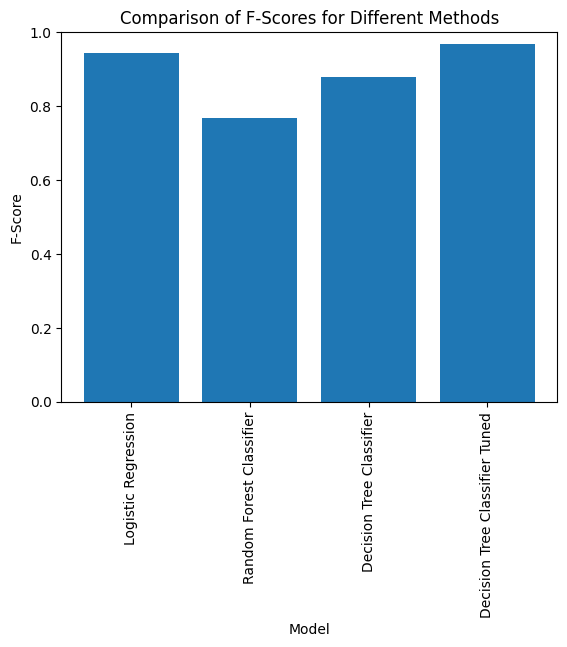

In [62]:
# We can plot the results of each model.

methods = ['Logistic Regression', 'Random Forest Classifier', 'Decision Tree Classifier', 'Decision Tree Classifier Tuned']
f_scores = [0.9440, 0.7690, 0.8786, 0.9671]

# Plot the F-scores
plt.bar(methods, f_scores)
plt.xlabel('Model')
plt.ylabel('F-Score')
plt.xticks(rotation='vertical')
plt.ylim(0., 1.0)
plt.title('Comparison of F-Scores for Different Methods')
plt.show()

In [60]:
# Lets look a bit deeper at these results.

accuracy = evaluator4.evaluate(predictions6, {evaluator4.metricName: "accuracy"})
precision = evaluator4.evaluate(predictions6, {evaluator4.metricName: "weightedPrecision"})
recall = evaluator4.evaluate(predictions6, {evaluator4.metricName: "weightedRecall"})

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9675919835109416
Precision: 0.9670684469609393
Recall: 0.9675919835109414


In [61]:
# Finally we'll validate this by using the validation data.

valid_predictions = dt_model4.transform(validation_data)
valid_evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')
f1_score_valid = valid_evaluator.evaluate(valid_predictions)
print("F1 Score on the validation set:", f1_score_valid)

F1 Score on the validation set: 0.9684032528156599


**There is no drop in performance when we change the dataset.**